# <B>The 7.8 Magnitude Kaikōura Earthquake on November 13, 2016, New Zealand</B>

<img src=https://upload.wikimedia.org/wikipedia/commons/f/f0/2016_Kaikoura_Earthquake_ShakeMap.jpg>

<B>The Kaikōura Earthquake was a complex earthquake involving the rupturing of 25 faults and lasted for around two minutes.</B>

<B> This Notebook is to look over the arrival times and appearance of the earthquake around New Zealand </B>

<B>Import libraries:</B>

In [166]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import pandas as pd
import numpy as np
client = Client("IRIS")

<B>Set the search parameters here</B>

Here we're looking for data covering a 24 hour period focused on the station closest to the epicenter (KHZ)

In [167]:
startt = UTCDateTime("2016-11-13")
endt = startt + 24 * 60 * 60
inv = client.get_stations(network="NZ", station="KHZ", channel="*", level="channel", starttime=startt, endtime=endt)

In [168]:
#This will give an overview of what the station data contains
print(inv)

Inventory created at 2020-09-29T17:31:51.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.45
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2016-11-13...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			NZ
		Stations (1):
			NZ.KHZ (Kahutara)
		Channels (21):
			NZ.KHZ.10.HHZ, NZ.KHZ.10.HHN, NZ.KHZ.10.HHE, NZ.KHZ.10.LHZ, 
			NZ.KHZ.10.LHN, NZ.KHZ.10.LHE, NZ.KHZ.10.UHZ, NZ.KHZ.10.UHN, 
			NZ.KHZ.10.UHE, NZ.KHZ.10.VHZ, NZ.KHZ.10.VHN, NZ.KHZ.10.VHE, 
			NZ.KHZ.20.BNZ, NZ.KHZ.20.BNN, NZ.KHZ.20.BNE, NZ.KHZ.20.HNZ, 
			NZ.KHZ.20.HNN, NZ.KHZ.20.HNE, NZ.KHZ.20.LNZ, NZ.KHZ.20.LNN, 
			NZ.KHZ.20.LNE


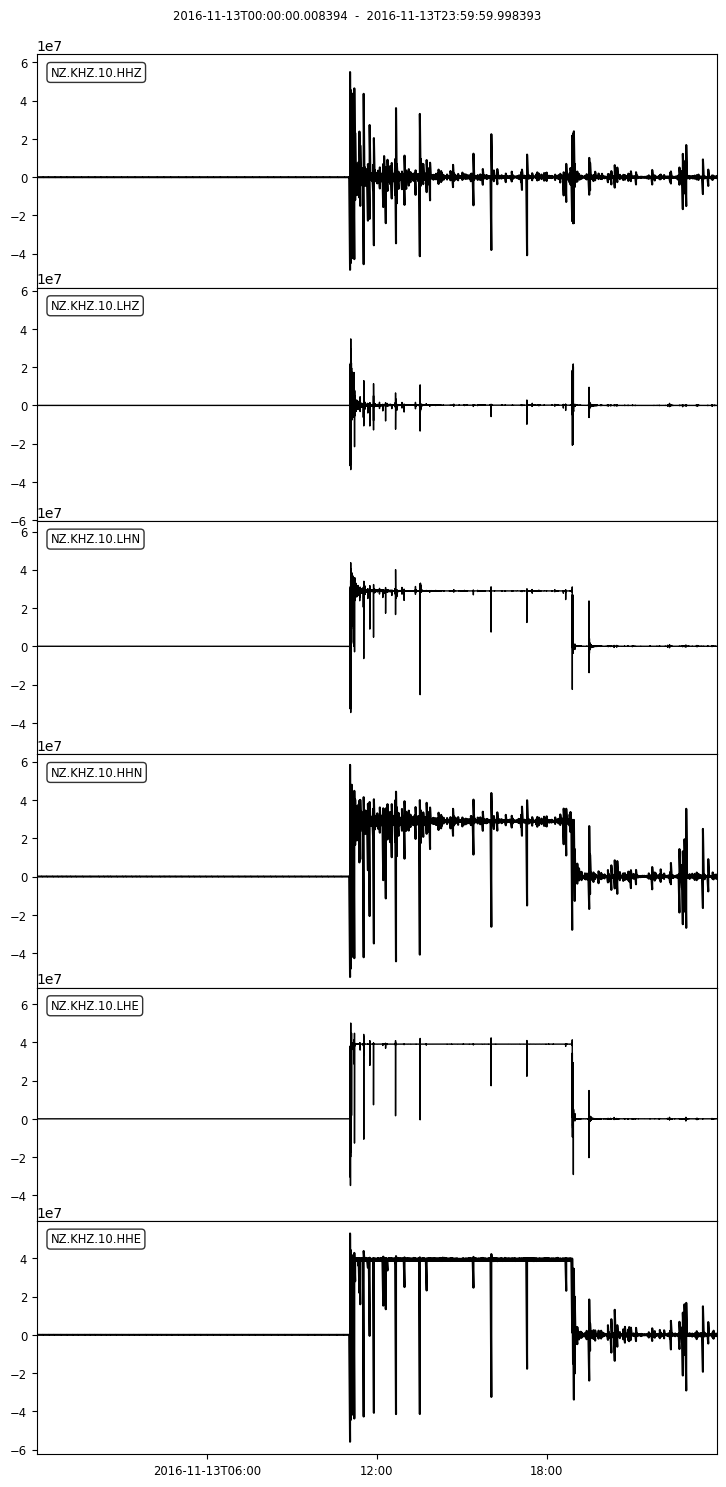

In [169]:
#To see which channels have data, set the channel variable to *
find_data=client.get_waveforms(network="NZ", station=station_ids, location='*', channel='*', starttime=startt, endtime=endt, attach_response=True)
#Then plot to easily see the options 
find_data.plot()
plt.show()

<B>Only six of the 21 channels collected data. I want to look at a station recording vertical motion, so one with the code "**Z". This leaves me with HHZ or LHZ. HHZ is a broadband frequency between 80-250 Hz, while LHZ is a long period of ~1Hz. In order to have more data to work with I selected HHZ</B>

In [170]:
st_raw=client.get_waveforms(network="NZ", station="KHZ", location='*', channel='HHZ', starttime=startt, endtime=endt, attach_response=True)

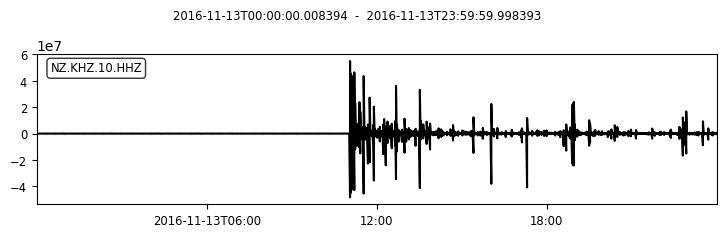

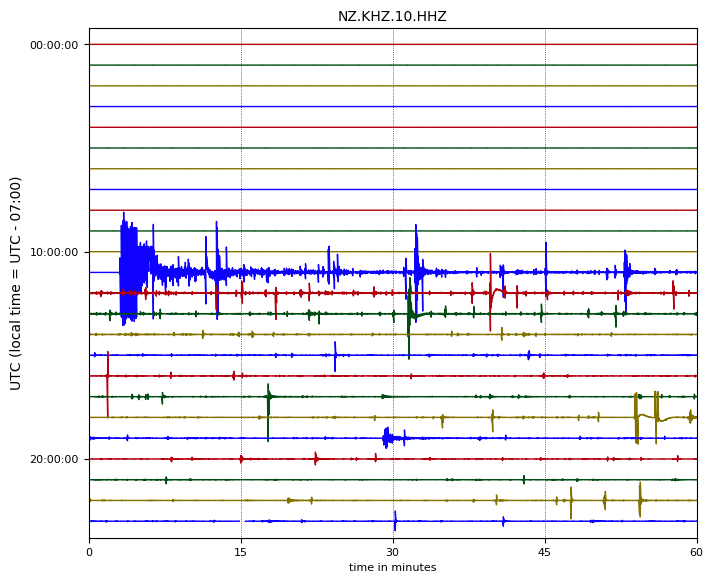

In [171]:
#we can isolate and take a look at the data from this channel in two different formats:
st_raw.plot()
plt.show()
st_raw.plot(type="dayplot", interval=60)
plt.show()

<B>Filter the data</B>

In [172]:
tr = st_raw[0]
tr_filt = tr.copy()
tr_filt.filter("bandpass", freqmin=0.3, freqmax=30, corners = 2, zerophase=True)

NZ.KHZ.10.HHZ | 2016-11-13T00:00:00.008394Z - 2016-11-13T23:14:52.958394Z | 100.0 Hz, 8369296 samples

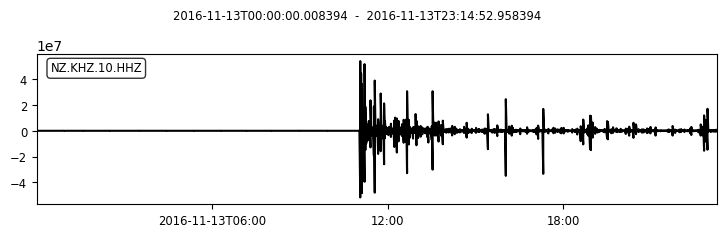

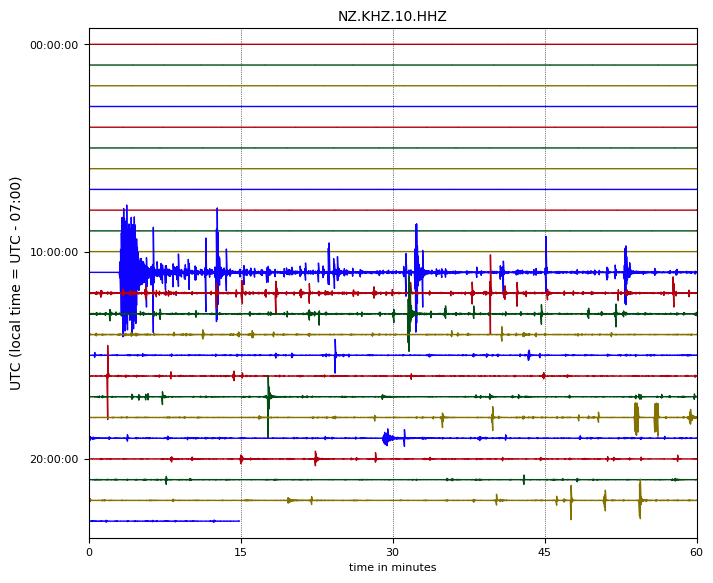

In [173]:
tr_filt.plot()
plt.show()
tr_filt.plot(type="dayplot", interval=60)
plt.show()

<B>From these graphs we can see that the earthquake started just after 11:00. We can use a short term / long term detector to get close to the time that the P-wave arrived. </B>

In [174]:
#Trim the data to be more exact: we want to start at 11:00 because that's the hour activity begins
new_start = UTCDateTime("2016-11-13T11:00:00")
new_tr = tr_filt.copy()
new_tr.trim(new_start,endt)

NZ.KHZ.10.HHZ | 2016-11-13T10:59:59.998394Z - 2016-11-13T23:14:52.958394Z | 100.0 Hz, 4409297 samples

In [175]:
from obspy.signal.trigger import recursive_sta_lta
from obspy.signal.trigger import plot_trigger
from obspy.signal.trigger import trigger_onset 

/opt/anaconda3/lib/python3.7/site-packages/obspy/signal/trigger.py:562: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.draw()
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


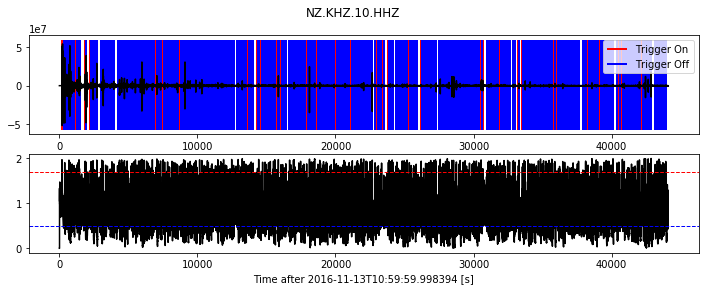

In [176]:
samprate = new_tr.stats.sampling_rate
cf = recursive_sta_lta(new_tr.data, int(5 * samprate), int(10 * samprate))
plot_trigger(new_tr, cf, 1.7, 0.5)

In [177]:
trig = trigger_onset(cf, 1.7, 0.5) / samprate
arrival = trig[0][0]
quaking_start = new_start + arrival
print(quaking_start)

2016-11-13T11:03:03.600000Z


<B>The detector found the event to start at around 11:03:03-11:03:04, to check this we can zoom in on our data to take a better look</B> 

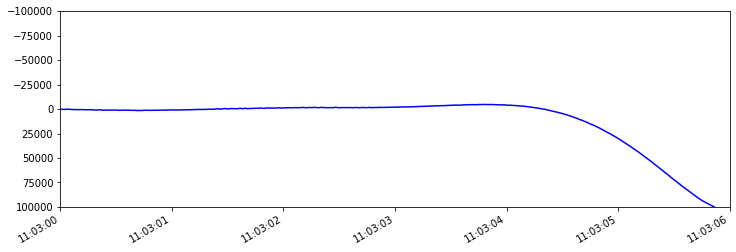

In [178]:
import datetime
startzoom = datetime.datetime(2016, 11, 13, 11, 3, 0)
endzoom = datetime.datetime(2016, 11, 13, 11, 3, 6)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(new_tr.times("matplotlib"), new_tr.data, "b-")
ax.xaxis_date()
ax.set_xlim([startzoom, endzoom])
ax.set_ylim(100000,-100000)
fig.autofmt_xdate()
plt.show()

<B>Zooming in we can see that the detector did a pretty good job finding where the earthquake starts</B>

Lets take a look at the spectrogram for the onset

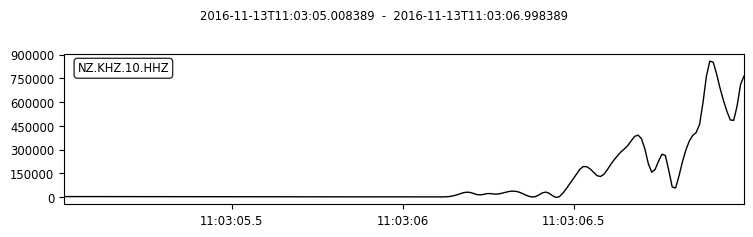

In [179]:
startspec = UTCDateTime('2016-11-13T11:03:05')
endspec = UTCDateTime('2016-11-13T11:03:07')
specdata = client.get_waveforms("NZ", "KHZ", "*", "HHZ", startspec, endspec)
specdata.plot()
plt.show()

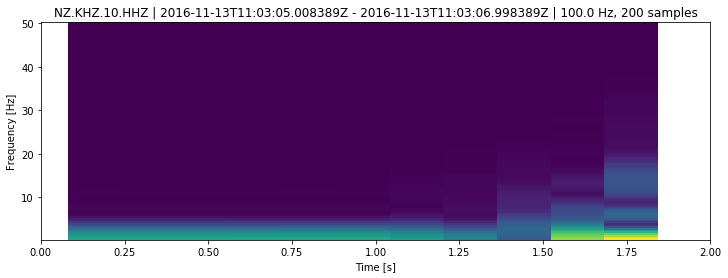

In [180]:
plt.rcParams['figure.figsize'] = (12, 4)
fig = specdata.spectrogram(per_lap=.5, wlen=2)

This can be expanded to observe the changes over the first minute of shaking. 

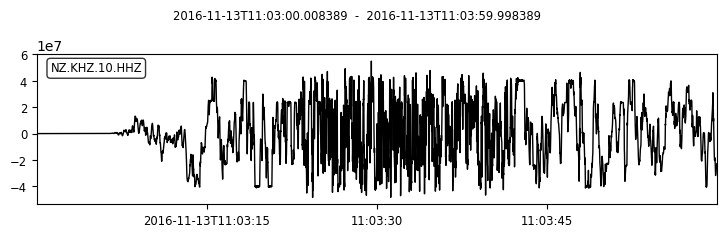

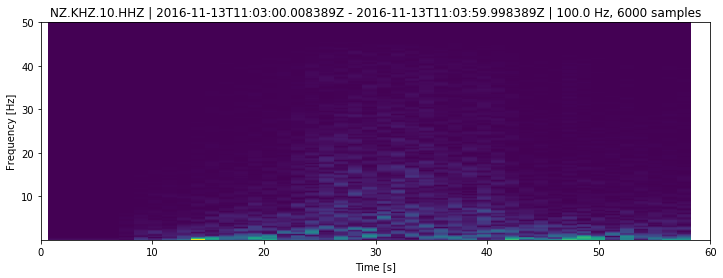

In [181]:
startspec2 = UTCDateTime('2016-11-13T11:03:00')
endspec2 = UTCDateTime('2016-11-13T11:04:00')
specdata2 = client.get_waveforms("NZ", "KHZ", "*", "HHZ", startspec2, endspec2)
specdata2.plot()
plt.show()
plt.rcParams['figure.figsize'] = (12, 4)
fig = specdata2.spectrogram(per_lap=.5, wlen=2)

This data shows that the start of the earthquake was dominated by low frequency signals that became more spread out as time went on. At around 11:03:30 there was very intense shaking leading to a hill in the data. As the data become more spread out after 11:03:45, the data was again dominated by low frequencies. 

In [182]:
#Lets take a look at the year of 2016
yearstart = UTCDateTime("2016-01-01T00:00:00")
yearend = UTCDateTime("2017-01-01T00:00:00")
client = Client("IRIS")
lat = -42.757 
lon = 173.077
minmag = 2.0
maxrad= 2
eventlist = client.get_events(starttime=yearstart, endtime=yearend, latitude=lat, longitude=lon, maxradius=maxrad, minmagnitude=minmag, catalog="NEIC PDE")
print(eventlist)

247 Event(s) in Catalog:
2016-12-29T03:00:20.650000Z | -41.633, +174.460 | 4.4 Mwr
2016-12-29T02:34:33.410000Z | -41.701, +174.557 | 5.3 Mww
...
2016-01-29T02:20:19.640000Z | -41.396, +174.398 | 4.1 mb
2016-01-27T23:24:41.930000Z | -43.550, +172.510 | 4.1 ml
To see all events call 'print(CatalogObject.__str__(print_all=True))'


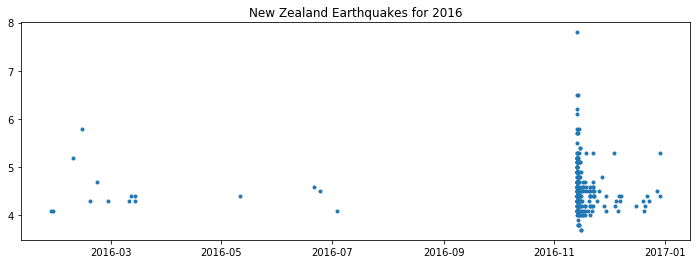

In [183]:
times = []
mags = []
for event in eventlist:
    times.append(event.origins[0].time.datetime)
    mags.append(event.magnitudes[0].mag)
mtimes = mdates.date2num(times)
plt.plot_date(mtimes,mags,marker='.')
plt.title("New Zealand Earthquakes for 2016")
plt.show()

<B>While New Zealand did have several earthquakes towards the start of the year, they don't compare to the amount of energy released and recorded on November 13th.</B>

## <B>Where were these earthquakes occuring?</B>

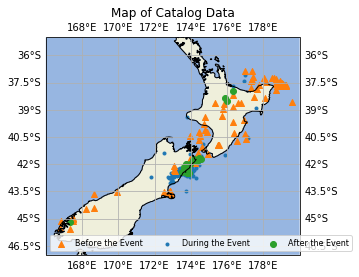

In [184]:
#Lets zoom in on the month of November:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
newrad = 7

monthstart = UTCDateTime("2016-11-01T00:00:00")
monthend = UTCDateTime("2016-12-01T00:00:00")
monthofevent = client.get_events(starttime=monthstart, endtime=monthend, latitude=lat, longitude=lon, maxradius=newrad, minmagnitude=minmag, catalog="NEIC PDE")

beforestart = UTCDateTime("2016-01-01T00:00:00")
beforeend = UTCDateTime("2016-11-01T00:00:00") 
beforeevent = client.get_events(starttime=beforestart, endtime=beforeend, latitude=lat, longitude=lon, maxradius=newrad, minmagnitude=minmag, catalog="NEIC PDE")

afterstart = UTCDateTime("2016-12-01T00:00:00")
afterend = UTCDateTime("2017-01-01T00:00:00") 
afterevent = client.get_events(starttime=afterstart, endtime=afterend, latitude=lat, longitude=lon, maxradius=newrad, minmagnitude=minmag, catalog="NEIC PDE")

lats = []
lons = []
for event in monthofevent:
    lats.append(event.origins[0].latitude)
    lons.append(event.origins[0].longitude)
beforelats = []
beforelons = []
for event in beforeevent:
    beforelats.append(event.origins[0].latitude)
    beforelons.append(event.origins[0].longitude)
afterlats = []
afterlons = []
for event in afterevent:
    afterlats.append(event.origins[0].latitude)
    afterlons.append(event.origins[0].longitude)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([166, 180, -47, -35], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, edgecolor='gray')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(xlocs=np.arange(166,180,2), draw_labels=True, crs=ccrs.PlateCarree())
the_event = ax.scatter(lons, lats, marker='.')
before_event = ax.scatter(beforelons, beforelats, marker='^')
after_event = ax.scatter(afterlons, afterlats, marker='o')
ax.legend((before_event,the_event,after_event),('Before the Event',"During the Event","After the Event"),scatterpoints=1, loc='lower left', ncol=3, fontsize=8) 
plt.title("Map of Catalog Data")
plt.show()

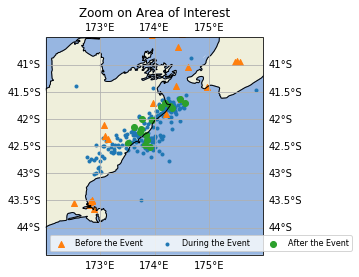

In [185]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([172, 176, -44.5, -40.5], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, edgecolor='gray')
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(xlocs=np.arange(172,176,1), draw_labels=True, crs=ccrs.PlateCarree())
the_event = ax.scatter(lons, lats, marker='.')
before_event = ax.scatter(beforelons, beforelats, marker='^')
after_event = ax.scatter(afterlons, afterlats, marker='o')
ax.legend((before_event,the_event,after_event),('Before the Event',"During the Event","After the Event"),scatterpoints=1, loc='lower left', ncol=3, fontsize=8) 
plt.title("Zoom on Area of Interest")
plt.show()

<B>The November event was highly isolated to the northern region of New Zealand's south island, while the event before and after varied in location all over the country.</B>

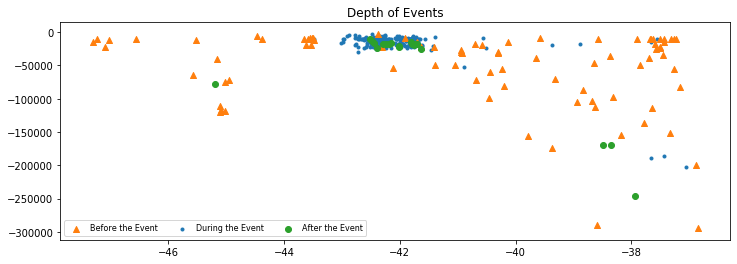

In [186]:
depthduring = []
depthafter = []
depthbefore = []

for event in monthofevent:
    depthduring.append(event.origins[0].depth)
for event in beforeevent:
    depthbefore.append(event.origins[0].depth)   
for event in afterevent:
    depthafter.append(event.origins[0].depth)

depthduring  = [-i for i in depthduring]
depthafter  = [-i for i in depthafter]
depthbefore  = [-i for i in depthbefore]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(lats,depthduring, marker='.')
ax.scatter(beforelats, depthbefore, marker='^')
ax.scatter(afterlats, depthafter, marker='o')
ax.legend((depthbeforetime,depthduringtime,depthaftertime),('Before the Event',"During the Event","After the Event"),scatterpoints=1, loc='lower left', ncol=3, fontsize=8) 
plt.title("Depth of Events")
plt.show()

In [190]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(lats,depthduring, marker='.')
ax.scatter(beforelats, depthbefore, marker='^')
ax.scatter(afterlats, depthafter, marker='o')
ax.set_ylim([-50000, 0])
ax.legend((depthbeforetime,depthduringtime,depthaftertime),('Before the Event',"During the Event","After the Event"),scatterpoints=1, loc='lower left', ncol=3, fontsize=8) 
plt.title("Zoom in of the Event Area")
plt.show()

<B>We can see that the earthquakes that occured in November were relatively shallow in the main area of impact, with those farther north being much deeper.</B>

## <B>How does this earthquake compare to events in New Zealand in the past 10 years, from 2010-2019?</B>

In [187]:
decadestart = UTCDateTime("2010-01-01T00:00:00")
decadeend = UTCDateTime("2020-01-01T00:00:00")
client = Client("IRIS")
lat = -42.757 
lon = 173.077
minmag = 2.0
maxrad= 6
eventlist = client.get_events(starttime=decadestart, endtime=decadeend, latitude=lat, longitude=lon, maxradius=maxrad, minmagnitude=minmag, catalog="NEIC PDE")
print(eventlist)
decadetimes = []
decademags = []
for event in eventlist:
    decadetimes.append(event.origins[0].time.datetime)
    decademags.append(event.magnitudes[0].mag)
dtimes = mdates.date2num(decadetimes)
plt.plot_date(dtimes,decademags,marker='.')
plt.title("New Zealand Earthquakes from 2010-2019")
plt.show()

1824 Event(s) in Catalog:
2019-12-17T16:14:22.438000Z | -44.869, +167.329 | 4.3 mb
2019-12-14T06:12:35.505000Z | -39.322, +176.109 | 5.0 Mww
...
2010-01-08T00:01:19.610000Z | -40.126, +174.909 | 3.9 ml
2010-01-04T21:29:31.840000Z | -45.252, +166.518 | 4.0 ml
To see all events call 'print(CatalogObject.__str__(print_all=True))'


<B>New Zealand has a long of seismic activity, however, this event was the largest experienced in the last 10 years</B>